In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import simulated_data as sim
import accuracy_metrics as ac
import os
import re

In [32]:
out_files = os.listdir("../../HMM_Test_Outputs/")
out_files = [out_files[i] for i in range(len(out_files)) if re.search("^sim.+tsv$", out_files[i])]
out_files = [out_files[i] for i in range(len(out_files)) if re.search("mix", out_files[i])]

In [33]:
file = out_files[0]
re.sub("^sim.+?_Rx[0-9]_([0-9]+?)_recomb.+$", "\\1", file)

'1'

In [34]:
out_files.sort()
out_files

['simAdmixedGenome_100_0_1_Rx1_0_recomb0.001_HMMoutput.tsv',
 'simAdmixedGenome_100_0_1_Rx1_0_recomb0.01_HMMoutput.tsv',
 'simAdmixedGenome_100_0_1_Rx1_0_recomb0.05_HMMoutput.tsv',
 'simAdmixedGenome_100_0_1_Rx1_0_recomb0.1_HMMoutput.tsv',
 'simAdmixedGenome_100_0_1_Rx1_0_recomb0.2_HMMoutput.tsv',
 'simAdmixedGenome_100_0_1_Rx1_0_recomb0.3_HMMoutput.tsv',
 'simAdmixedGenome_100_0_1_Rx1_0_recomb0.4_HMMoutput.tsv',
 'simAdmixedGenome_100_0_1_Rx1_0_recomb0.5_HMMoutput.tsv',
 'simAdmixedGenome_100_0_1_Rx1_0_recomb0.6_HMMoutput.tsv',
 'simAdmixedGenome_100_0_1_Rx1_0_recomb0.7_HMMoutput.tsv',
 'simAdmixedGenome_100_0_1_Rx1_0_recomb0.8_HMMoutput.tsv',
 'simAdmixedGenome_100_0_1_Rx1_0_recomb0.9_HMMoutput.tsv',
 'simAdmixedGenome_100_0_1_Rx1_1_recomb0.001_HMMoutput.tsv',
 'simAdmixedGenome_100_0_1_Rx1_1_recomb0.01_HMMoutput.tsv',
 'simAdmixedGenome_100_0_1_Rx1_1_recomb0.05_HMMoutput.tsv',
 'simAdmixedGenome_100_0_1_Rx1_1_recomb0.1_HMMoutput.tsv',
 'simAdmixedGenome_100_0_1_Rx1_1_recomb0.2_HMMou

In [35]:
def get_accuracy_results(out_files, base_dir):

    accuracies = []
    skew = []
    recomb_rate = []
    admix = []
    dataset = []
    repeat = []
    for file in out_files:
        pred = pd.read_csv(base_dir + file, sep="\t", index_col=False)
        original_file = re.sub("_recomb.+", ".tsv", file)
        try:
            truth = pd.read_csv("Data/"+original_file, sep= "\t", index_col=False)
            accuracies.append(ac.accuracy(pred, truth))
            _, s = ac.pivot_accuracy(pred, truth)
            skew.append(s)
            rr = re.sub("^.+recomb(.+)_HMMoutput.tsv", "\\1", file)
            recomb_rate.append(rr)
            dataset.append(re.sub("^sim[a-zA-Z]+?Genome_([0-9]+?)_.+$", "\\1", file))
            repeat.append(re.sub("^sim.+?_Rx[0-9]+?_([0-9])_recomb.+$", "\\1", file))
            if re.search("Rx", file):
                ad = re.sub("^.+Rx([0-9]+)_.+", "\\1", file)
                admix.append(ad)
            else:
                admix.append(0)
        except FileNotFoundError:
            try:
            #truth = pd.read_csv("../../simulated_files/"+original_file, sep= "\t", index_col=False)
            # Lauryn added because files were all missing position 0, change back to original above when issue is fixed!
                truth = pd.read_csv("../../simulated_files/"+original_file, sep= "\t", index_col=False)#.iloc[1:]
                if len(truth) > len(pred):
                    truth = truth.iloc[1:]
                accuracies.append(ac.accuracy(pred, truth))
                _, s = ac.pivot_accuracy(pred, truth)
                skew.append(s)
                rr = re.sub("^.+recomb(.+)_HMMoutput.tsv", "\\1", file)
                recomb_rate.append(rr)
                dataset.append(re.sub("^sim[a-zA-Z]+?Genome_([0-9]+?)_.+$", "\\1", file))
                repeat.append(re.sub("^sim.+?_Rx[0-9]+?_([0-9])_recomb.+$", "\\1", file))
                if re.search("Rx", file):
                    ad = re.sub("^.+Rx([0-9]+)_.+", "\\1", file)
                    admix.append(ad)
                else:
                    admix.append(0)
            except FileNotFoundError:
                print("NOT FOUND", original_file)
        
    results = pd.DataFrame({"test": out_files, "recomb": recomb_rate, "N_admix":admix, "accuracy":accuracies, "skew":skew, "dataset":dataset, "repeat":repeat}, dtype=float)
    return results

In [45]:
def plot_accuracy(results, log_recomb=False):
    plt.scatter(data=results, x="recomb", y="accuracy", c="N_admix")
    plt.colorbar()
    plt.xlabel("Recombination rate", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if log_recomb:
        plt.xscale("log")
    plt.title("Accuracy at varying recombination rate, colored by Rx")
    
def plot_skew(results, log=True):
    if log:
        results["log_skew"] = results["skew"].apply(lambda x: np.log2(x+1))
        plt.scatter(data=results, x="recomb", y="log_skew", c="N_admix")
        plt.ylabel("log2(Skew+1)")
    else:
        plt.scatter(data=results, x="recomb", y="skew", c="N_admix")
        plt.ylabel("Skew")
    plt.colorbar()
    plt.xlabel("Recombination rate")
    plt.title("Skew at varying recombination rate, colored by Rx")
    
    
def plot_accuracy_with_lines(results, groups, log=True, ylim=(0,1)):
    plt.figure()
    for g in groups.keys():
        for repeat in [0.0, 1.0]:
            data = results.loc[((results.N_admix==g) & (results.repeat==repeat))]
            plt.scatter(data=data, x="recomb", y="accuracy", c=groups[g])
            plt.plot("recomb", "accuracy", data=data, c=groups[g])
    plt.xlabel("Recombination rate", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.xscale("log")
    plt.ylim(ylim)
    plt.show()
    
        

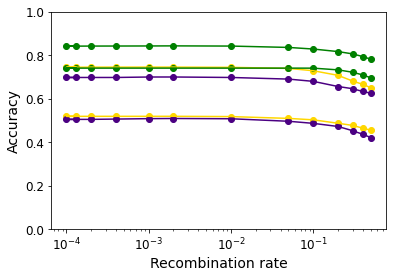

{1.0: 'gold', 5.0: 'green', 10.0: 'indigo'}


In [134]:
color_map = {1.0:"gold", 5.0:"green", 10.0:"indigo"}
plot_accuracy_with_lines(results.loc[results.dataset==5000], color_map, ylim=(0,1))
print(color_map)

In [110]:
results = get_accuracy_results(out_files,"../../HMM_Test_Outputs/")
r5000 = results.loc[results.dataset==5000]
r5000.sort_values(by="test")

,test,recomb,N_admix,accuracy,skew,dataset,repeat
96,simAdmixedGenome_5000_0_1_Rx10_0_recomb0.00013...,0.00013,10.0,0.504900,0.25,5000.0,0.0
97,simAdmixedGenome_5000_0_1_Rx10_0_recomb0.0001_...,0.00010,10.0,0.505000,0.25,5000.0,0.0
98,simAdmixedGenome_5000_0_1_Rx10_0_recomb0.0002_...,0.00020,10.0,0.505100,0.25,5000.0,0.0
99,simAdmixedGenome_5000_0_1_Rx10_0_recomb0.0004_...,0.00040,10.0,0.506500,0.25,5000.0,0.0
100,simAdmixedGenome_5000_0_1_Rx10_0_recomb0.001_H...,0.00100,10.0,0.508400,0.25,5000.0,0.0
...,...,...,...,...,...,...,...
221,simAdmixedGenome_5000_0_1_Rx5_1_recomb0.1_HMMo...,0.10000,5.0,0.828566,1.00,5000.0,1.0
222,simAdmixedGenome_5000_0_1_Rx5_1_recomb0.2_HMMo...,0.20000,5.0,0.816863,1.80,5000.0,1.0
223,simAdmixedGenome_5000_0_1_Rx5_1_recomb0.3_HMMo...,0.30000,5.0,0.806261,3.20,5000.0,1.0
224,simAdmixedGenome_5000_0_1_Rx5_1_recomb0.4_HMMo...,0.40000,5.0,0.793959,12.80,5000.0,1.0


In [95]:
results.dataset.unique()

array([5000.,  100.])

In [35]:
results.loc[((results.dataset == 5000) & (results.N_admix == 1))]

,test,recomb,N_admix,accuracy,skew,dataset
151,simAdmixedGenome_5000_0_1_Rx1_0_recomb0.0001_H...,0.00010,1.0,0.744400,1.0,5000.0
142,simAdmixedGenome_5000_0_1_Rx1_1_recomb0.0001_H...,0.00010,1.0,0.519100,0.5,5000.0
172,simAdmixedGenome_5000_0_1_Rx1_1_recomb0.00013_...,0.00013,1.0,0.519100,0.5,5000.0
12,simAdmixedGenome_5000_0_1_Rx1_0_recomb0.00013_...,0.00013,1.0,0.745100,1.0,5000.0
29,simAdmixedGenome_5000_0_1_Rx1_1_recomb0.0002_H...,0.00020,1.0,0.519100,0.5,5000.0
40,simAdmixedGenome_5000_0_1_Rx1_0_recomb0.0002_H...,0.00020,1.0,0.745300,1.0,5000.0
122,simAdmixedGenome_5000_0_1_Rx1_1_recomb0.0004_H...,0.00040,1.0,0.519100,0.5,5000.0
164,simAdmixedGenome_5000_0_1_Rx1_0_recomb0.0004_H...,0.00040,1.0,0.745400,1.0,5000.0
125,simAdmixedGenome_5000_0_1_Rx1_1_recomb0.001_HM...,0.00100,1.0,0.519100,0.5,5000.0
21,simAdmixedGenome_5000_0_1_Rx1_0_recomb0.001_HM...,0.00100,1.0,0.745500,1.0,5000.0


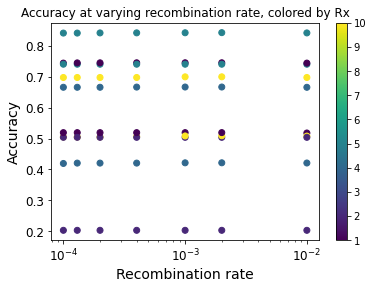

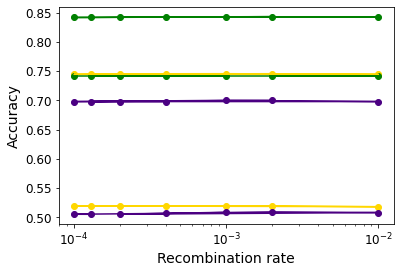

In [96]:
#colors={1.0:"red", 2.0:"blue", 5.0:"green",10.0:"black", 4.0:"purple" }
#results = results.sort_values(by=["test", "recomb"])
plot_accuracy(results.loc[(results.dataset == 5000)], log_recomb=True)
color_map = {1.0:"gold", 5.0:"green", 10.0:"indigo"}
plot_accuracy_with_lines(results.loc[results.dataset==5000], color_map)

N_admix
1.0     AxesSubplot(0.125,0.125;0.775x0.755)
2.0     AxesSubplot(0.125,0.125;0.775x0.755)
4.0     AxesSubplot(0.125,0.125;0.775x0.755)
5.0     AxesSubplot(0.125,0.125;0.775x0.755)
10.0    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

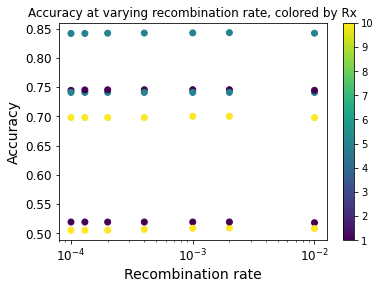

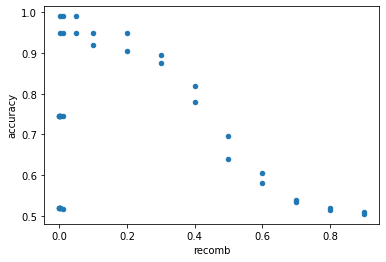

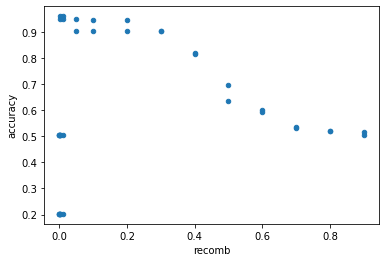

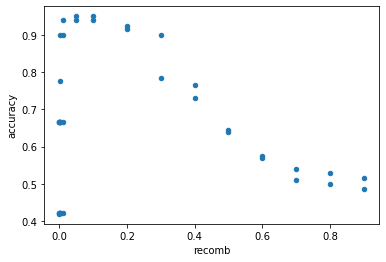

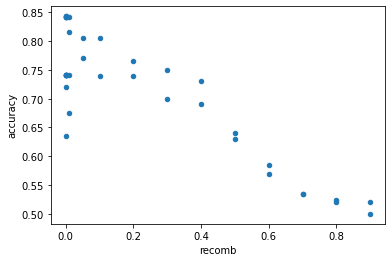

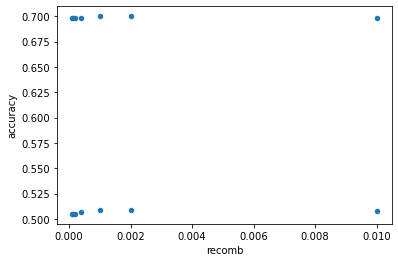

In [51]:
#colors={1.0:"red", 2.0:"blue", 5.0:"green",10.0:"black", 4.0:"purple" }
#results = results.sort_values(by=["test", "recomb"])
plot_accuracy(results.loc[((results.dataset == 5000) & results.N_admix.isin([1.0, 5.0, 10.0]))], log_recomb=True)
results.groupby("N_admix").plot(x="recomb", y="accuracy", kind="scatter")

<ipython-input-6-79dc4ac2403f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["log_skew"] = results["skew"].apply(lambda x: np.log2(x+1))


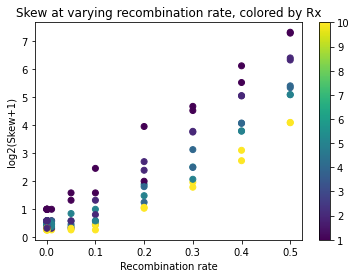

In [9]:
plot_skew(results[results.dataset==5000])

<ipython-input-6-79dc4ac2403f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["log_skew"] = results["skew"].apply(lambda x: np.log2(x+1))


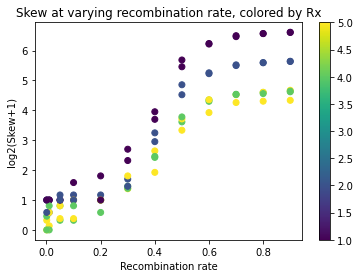

In [10]:
plot_skew(results[results.dataset==100])

## LOG10 Results

In [37]:
out_files = os.listdir("../../HMM_Log10_Test_Outputs/")
out_files = [out_files[i] for i in range(len(out_files)) if re.search("^sim.+tsv$", out_files[i])]
out_files = [out_files[i] for i in range(len(out_files)) if re.search("mix", out_files[i])]

In [38]:
res_log = get_accuracy_results(out_files, "../../HMM_Log10_Test_Outputs/")


In [39]:
res_log["dataset"] = res_log["dataset"].astype(int)

In [40]:
res_log.loc[res_log.dataset==100]

,test,recomb,N_admix,accuracy,skew,dataset,repeat
6,simAdmixedGenome_100_0_1_Rx1_1_recomb0.4_HMMou...,0.40,1.0,0.780,14.500,100,1.0
7,simAdmixedGenome_100_0_1_Rx5_0_recomb0.1_HMMou...,0.10,5.0,0.740,1.000,100,0.0
8,simAdmixedGenome_100_0_1_Rx4_0_recomb0.2_HMMou...,0.20,4.0,0.915,0.500,100,0.0
9,simAdmixedGenome_100_0_1_Rx2_1_recomb0.1_HMMou...,0.10,2.0,0.945,1.000,100,1.0
10,simAdmixedGenome_100_0_1_Rx2_0_recomb0.8_HMMou...,0.80,2.0,0.520,47.250,100,0.0
...,...,...,...,...,...,...,...
160,simAdmixedGenome_100_0_1_Rx5_0_recomb0.05_HMMo...,0.05,5.0,0.770,0.750,100,0.0
161,simAdmixedGenome_100_0_1_Rx5_1_recomb0.9_HMMou...,0.90,5.0,0.520,19.200,100,1.0
162,simAdmixedGenome_100_0_1_Rx2_0_recomb0.9_HMMou...,0.90,2.0,0.515,48.750,100,0.0
163,simAdmixedGenome_100_0_1_Rx4_0_recomb0.3_HMMou...,0.30,4.0,0.785,1.625,100,0.0


In [41]:
res_log = res_log.sort_values(by="recomb")

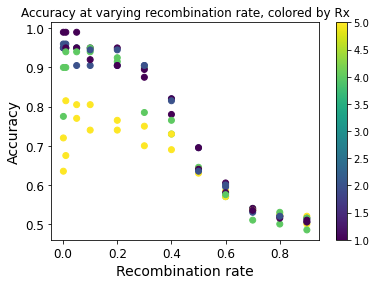

In [42]:
plot_accuracy(res_log.loc[res_log.dataset==100])

<ipython-input-36-d97745cfe0a5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["log_skew"] = results["skew"].apply(lambda x: np.log2(x+1))


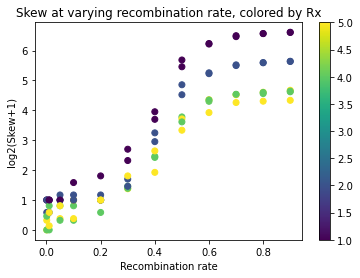

In [43]:
plot_skew(res_log.loc[res_log.dataset==100])

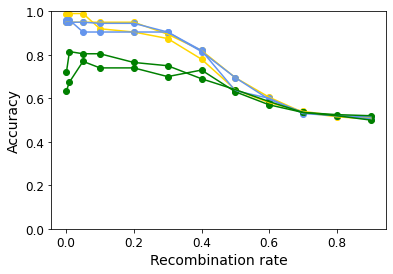

In [53]:
color_map = {1.0:"gold", 2.0:u"cornflowerblue", 5.0:"green"}
plot_accuracy_with_lines(res_log.loc[res_log.dataset==100], color_map)

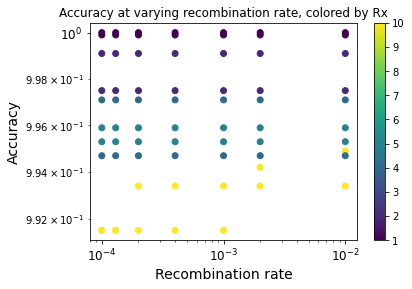

In [124]:
plot_accuracy(res_log.loc[res_log.dataset==5000], log_recomb=True)
plt.yscale("log")


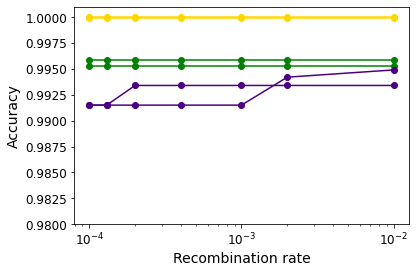

In [138]:
color_map = {1.0:"gold", 5.0:"green", 10.0:"indigo"}
plot_accuracy_with_lines(res_log.loc[res_log.dataset==5000], color_map, ylim=(0.98, 1.001))


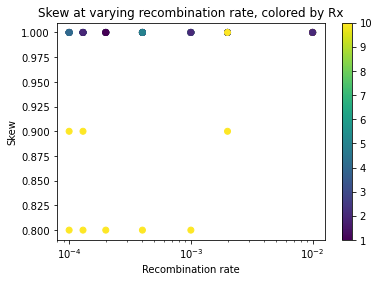

In [51]:
plot_skew(res_log.loc[res_log.dataset==5000], log=False)
plt.xscale("log")

In [49]:
res_log.head()

,test,recomb,N_admix,accuracy,skew,dataset
0,simAdmixedGenome_5000_0_1_Rx1_1_recomb0.001_HM...,0.0010,1.0,0.9999,1.0,5000
1,simAdmixedGenome_5000_0_1_Rx1_0_recomb0.002_HM...,0.0020,1.0,1.0000,1.0,5000
2,simAdmixedGenome_5000_0_1_Rx10_1_recomb0.0004_...,0.0004,10.0,0.9934,1.0,5000
3,simAdmixedGenome_5000_0_1_Rx5_0_recomb0.002_HM...,0.0020,5.0,0.9959,1.0,5000
4,simAdmixedGenome_5000_0_1_Rx5_1_recomb0.001_HM...,0.0010,5.0,0.9953,1.0,5000
